In [1]:
!pip install botorch
!pip install rdkit
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 7.2 MB/s 
     |████████████████████████████████| 245 kB 59.7 MB/s 
     |████████████████████████████████| 152 kB 55.6 MB/s 
     |████████████████████████████████| 727 kB 50.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 8.7 MB/s 


In [2]:
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import rdmolfiles, rdmolops, AllChem, Draw, rdDepictor, Descriptors
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Fingerprints import FingerprintMols

from IPython.display import SVG
from IPython.display import HTML
from IPython.display import display

import torch
from botorch.models import SingleTaskGP
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from botorch.models.multitask import MultiTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.optim import Adam
from collections import defaultdict
from tqdm import tqdm

#**Load Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
srims = pd.read_csv("./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Data/polymer_solvent_mixture_srims.csv")
srims.tail()

,Unnamed: 0,|M|n|||4|||elm|C-C-C.R,|M|n|||4|||elm|C-C.C-R,|M|n|||4|||elm|C.C-C-R,|M|n|||4|||elm|C.C-C-C,|M|n|||4|||elm|C-C.C-C,|M|n|||4|||elm|C.C-C=C,|M|n|||4|||elm|C-C.C=C,|S|n|||4|||elm|C-C(-C)-C,|S|n|||4|||elm|C(-C-R)-R,...,|S|n|||4|||elm|C=C-O.R,|S|n|||4|||elm|C-C.O-R,|S|n|||4|||elm|C-C=C-R,|S|n|||4|||elm|C=C-R.O,|M|n|||4|||elm|C(-O)-O.O,|S|n|||4|||elm|C.C(-O)-O,|S|n|||4|||elm|C-O.O-R,|S|n|||4|||elm|C(-O)-O.R,|S|n|||4|||elm|C-O-C-O,|S|n|||4|||elm|C(-O)-O-R
81,"('poly(alpha-methylstyrene)', 'trans-decahydro...",28,22,40,166,66,70,33,3,1,...,0,0,0,0,0,0,0,0,0,0
82,"('poly(alpha-methylstyrene)', 'cyclohexane')",12,12,24,78,36,42,18,1,1,...,0,0,0,0,0,0,0,0,0,0
83,"('poly(2-ethyl-2-oxazoline)', 'water')",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84,"('poly(2,6-dimethyl-1,4-phenylene oxide)', 'to...",2,4,7,22,20,112,27,0,0,...,1,4,1,1,0,0,0,0,0,0
85,"('poly(1,3-dioxolane)', 'water')",0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,1,1


In [5]:
srims = srims.rename(columns={"Unnamed: 0":"Combinations"})
srims

,Combinations,|M|n|||4|||elm|C-C-C.R,|M|n|||4|||elm|C-C.C-R,|M|n|||4|||elm|C.C-C-R,|M|n|||4|||elm|C.C-C-C,|M|n|||4|||elm|C-C.C-C,|M|n|||4|||elm|C.C-C=C,|M|n|||4|||elm|C-C.C=C,|S|n|||4|||elm|C-C(-C)-C,|S|n|||4|||elm|C(-C-R)-R,...,|S|n|||4|||elm|C=C-O.R,|S|n|||4|||elm|C-C.O-R,|S|n|||4|||elm|C-C=C-R,|S|n|||4|||elm|C=C-R.O,|M|n|||4|||elm|C(-O)-O.O,|S|n|||4|||elm|C.C(-O)-O,|S|n|||4|||elm|C-O.O-R,|S|n|||4|||elm|C(-O)-O.R,|S|n|||4|||elm|C-O-C-O,|S|n|||4|||elm|C(-O)-O-R
0,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,0,0,0,0,0,0,0
1,"('polystyrene', 'cyclohexanol')",12,12,18,60,30,42,18,0,1,...,0,0,0,0,0,0,0,0,0,0
2,"('polystyrene', 'methylcyclopentane')",14,12,18,68,30,42,18,1,1,...,0,0,0,0,0,0,0,0,0,0
3,"('polystyrene', 'nitroethane')",0,2,6,4,5,14,3,0,1,...,0,0,0,0,0,0,0,0,0,0
4,"('polystyrene', 'ethyl acetate')",0,4,12,8,10,28,6,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,"('poly(alpha-methylstyrene)', 'trans-decahydro...",28,22,40,166,66,70,33,3,1,...,0,0,0,0,0,0,0,0,0,0
82,"('poly(alpha-methylstyrene)', 'cyclohexane')",12,12,24,78,36,42,18,1,1,...,0,0,0,0,0,0,0,0,0,0
83,"('poly(2-ethyl-2-oxazoline)', 'water')",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84,"('poly(2,6-dimethyl-1,4-phenylene oxide)', 'to...",2,4,7,22,20,112,27,0,0,...,1,4,1,1,0,0,0,0,0,0


In [ ]:
# srims.Combinations[0]

"('polystyrene', 'methylcyclohexane')"

In [ ]:
# srims.Combinations[0].split("'")

['(', 'polystyrene', ', ', 'methylcyclohexane', ')']

In [ ]:
# srims.Combinations[1].split("'")[1]

'polystyrene'

In [6]:
df_original = pd.read_csv("./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Data/Binary Polymer Solution Cloud Point Database (d_dropped).csv")
df_original.head()

,Polymer,Polymer CAS,Polymer SMILES,Solvent,Solvent CAS,Solvent SMILES,Mw(Da),PDI,ϕ,w,P(Mpa),CP(°C),1-Phase,Ref.,Polymer Mols,Solvent Mols
0,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclohexane,108-87-2,CC1CCCCC1,17500,1.06,0.11406,0.15000,82.81,21.34,positive,doi.org/10.1002/macp.1994.021950233,<rdkit.Chem.rdchem.Mol object at 0x7f5ccfffa580>,<rdkit.Chem.rdchem.Mol object at 0x7f5ccff349e0>
1,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclohexane,108-87-2,CC1CCCCC1,17500,1.06,0.18196,0.23366,80.00,21.18,positive,doi.org/10.1002/macp.1994.021950233,<rdkit.Chem.rdchem.Mol object at 0x7f5ccfffa5f0>,<rdkit.Chem.rdchem.Mol object at 0x7f5ccff34a50>
2,polystyrene,9003-53-6,*C(C*)c1ccccc1,cyclohexanol,108-93-0,OC1CCCCC1,78800,1.12,0.00632,0.00700,0.10,73.99,positive,doi.org/10.1021/je0504865,<rdkit.Chem.rdchem.Mol object at 0x7f5ccfffa660>,<rdkit.Chem.rdchem.Mol object at 0x7f5ccff34ac0>
3,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclopentane,96-37-7,CC1CCCC1,22100,1.03,0.11401,0.15300,1.02,27.42,positive,doi.org/10.1021/ma00107a011,<rdkit.Chem.rdchem.Mol object at 0x7f5ccfffa6d0>,<rdkit.Chem.rdchem.Mol object at 0x7f5ccff34b30>
4,polystyrene,9003-53-6,*C(C*)c1ccccc1,nitroethane,79-24-3,CC[N+](=O)[O-],13500,1.06,0.17990,0.17990,4.35,6.08,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f5ccfffa740>,<rdkit.Chem.rdchem.Mol object at 0x7f5ccff34ba0>


In [7]:
add = df_original.loc[:, ["Polymer", "Solvent", "Mw(Da)", "PDI", "ϕ", "w", "P(Mpa)", "1-Phase", "CP(°C)"]]
print(add.shape)
add.head()

(4833, 9)


,Polymer,Solvent,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,polystyrene,methylcyclohexane,17500,1.06,0.11406,0.15000,82.81,positive,21.34
1,polystyrene,methylcyclohexane,17500,1.06,0.18196,0.23366,80.00,positive,21.18
2,polystyrene,cyclohexanol,78800,1.12,0.00632,0.00700,0.10,positive,73.99
3,polystyrene,methylcyclopentane,22100,1.03,0.11401,0.15300,1.02,positive,27.42
4,polystyrene,nitroethane,13500,1.06,0.17990,0.17990,4.35,positive,6.08


In [8]:
for idx in add.index:
  add.loc[idx, "Combinations"] = f"('{add.Polymer[idx]}', '{add.Solvent[idx]}')"
add

,Polymer,Solvent,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C),Combinations
0,polystyrene,methylcyclohexane,17500,1.06,0.11406,0.15000,82.81,positive,21.34,"('polystyrene', 'methylcyclohexane')"
1,polystyrene,methylcyclohexane,17500,1.06,0.18196,0.23366,80.00,positive,21.18,"('polystyrene', 'methylcyclohexane')"
2,polystyrene,cyclohexanol,78800,1.12,0.00632,0.00700,0.10,positive,73.99,"('polystyrene', 'cyclohexanol')"
3,polystyrene,methylcyclopentane,22100,1.03,0.11401,0.15300,1.02,positive,27.42,"('polystyrene', 'methylcyclopentane')"
4,polystyrene,nitroethane,13500,1.06,0.17990,0.17990,4.35,positive,6.08,"('polystyrene', 'nitroethane')"
...,...,...,...,...,...,...,...,...,...,...
4828,"poly(1,3-dioxolane)",water,50000,1.50,0.44220,0.50560,0.10,negative,63.14,"('poly(1,3-dioxolane)', 'water')"
4829,"poly(1,3-dioxolane)",water,50000,1.50,0.09225,0.11590,0.10,negative,71.08,"('poly(1,3-dioxolane)', 'water')"
4830,"poly(1,3-dioxolane)",water,50000,1.50,0.11156,0.13940,0.10,negative,72.63,"('poly(1,3-dioxolane)', 'water')"
4831,"poly(1,3-dioxolane)",water,50000,1.50,0.34850,0.40830,0.10,negative,73.50,"('poly(1,3-dioxolane)', 'water')"


In [19]:
df_com = pd.merge(srims, add, how="inner", on="Combinations")
#The position of the key for merge is based on first (left) dataset. So "Combinations" column is at first column.
print(df_com.shape)
df_com.head()

(4833, 322)


,Combinations,|M|n|||4|||elm|C-C-C.R,|M|n|||4|||elm|C-C.C-R,|M|n|||4|||elm|C.C-C-R,|M|n|||4|||elm|C.C-C-C,|M|n|||4|||elm|C-C.C-C,|M|n|||4|||elm|C.C-C=C,|M|n|||4|||elm|C-C.C=C,|S|n|||4|||elm|C-C(-C)-C,|S|n|||4|||elm|C(-C-R)-R,...,|S|n|||4|||elm|C(-O)-O-R,Polymer,Solvent,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,polystyrene,methylcyclohexane,17500,1.06,0.11406,0.15000,82.81,positive,21.34
1,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,polystyrene,methylcyclohexane,17500,1.06,0.18196,0.23366,80.00,positive,21.18
2,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,polystyrene,methylcyclohexane,405000,2.83,0.01836,0.02500,4.09,positive,56.35
3,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,polystyrene,methylcyclohexane,16100,1.06,0.09728,0.12870,51.68,positive,19.63
4,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,polystyrene,methylcyclohexane,297000,5.45,0.04374,0.05900,0.10,positive,57.82


In [20]:
#Drop Polymer and Solvent  columns
df_com = df_com.drop(["Polymer", "Solvent"], axis=1)
print(df_com.shape)
df_com.head()

(4833, 320)


,Combinations,|M|n|||4|||elm|C-C-C.R,|M|n|||4|||elm|C-C.C-R,|M|n|||4|||elm|C.C-C-R,|M|n|||4|||elm|C.C-C-C,|M|n|||4|||elm|C-C.C-C,|M|n|||4|||elm|C.C-C=C,|M|n|||4|||elm|C-C.C=C,|S|n|||4|||elm|C-C(-C)-C,|S|n|||4|||elm|C(-C-R)-R,...,|S|n|||4|||elm|C(-O)-O.R,|S|n|||4|||elm|C-O-C-O,|S|n|||4|||elm|C(-O)-O-R,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,positive,21.34
1,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,positive,21.18
2,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,405000,2.83,0.01836,0.02500,4.09,positive,56.35
3,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,16100,1.06,0.09728,0.12870,51.68,positive,19.63
4,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,297000,5.45,0.04374,0.05900,0.10,positive,57.82


In [22]:
#For 1-Phase, use LabelEncoder to transfer str to int.
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit_transform(df_com["1-Phase"])

df_com["1-Phase"] = LE.fit_transform(df_com["1-Phase"])
df_com.head()

,Combinations,|M|n|||4|||elm|C-C-C.R,|M|n|||4|||elm|C-C.C-R,|M|n|||4|||elm|C.C-C-R,|M|n|||4|||elm|C.C-C-C,|M|n|||4|||elm|C-C.C-C,|M|n|||4|||elm|C.C-C=C,|M|n|||4|||elm|C-C.C=C,|S|n|||4|||elm|C-C(-C)-C,|S|n|||4|||elm|C(-C-R)-R,...,|S|n|||4|||elm|C(-O)-O.R,|S|n|||4|||elm|C-O-C-O,|S|n|||4|||elm|C(-O)-O-R,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,1,21.34
1,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,1,21.18
2,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,405000,2.83,0.01836,0.02500,4.09,1,56.35
3,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,16100,1.06,0.09728,0.12870,51.68,1,19.63
4,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,297000,5.45,0.04374,0.05900,0.10,1,57.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,"('poly(1,3-dioxolane)', 'water')",0,0,0,0,0,0,0,0,0,...,1,1,1,50000,1.50,0.44220,0.50560,0.10,0,63.14
4829,"('poly(1,3-dioxolane)', 'water')",0,0,0,0,0,0,0,0,0,...,1,1,1,50000,1.50,0.09225,0.11590,0.10,0,71.08
4830,"('poly(1,3-dioxolane)', 'water')",0,0,0,0,0,0,0,0,0,...,1,1,1,50000,1.50,0.11156,0.13940,0.10,0,72.63
4831,"('poly(1,3-dioxolane)', 'water')",0,0,0,0,0,0,0,0,0,...,1,1,1,50000,1.50,0.34850,0.40830,0.10,0,73.50


Feature Scaling

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
f_std = df_com.copy()
f_std.loc[:, ["Mw(Da)", "P(Mpa)", "CP(°C)"]] = scaler.fit_transform(f_std.loc[:, ["Mw(Da)", "P(Mpa)", "CP(°C)"]])

In [28]:
f_std.head()

,Combinations,|M|n|||4|||elm|C-C-C.R,|M|n|||4|||elm|C-C.C-R,|M|n|||4|||elm|C.C-C-R,|M|n|||4|||elm|C.C-C-C,|M|n|||4|||elm|C-C.C-C,|M|n|||4|||elm|C.C-C=C,|M|n|||4|||elm|C-C.C=C,|S|n|||4|||elm|C-C(-C)-C,|S|n|||4|||elm|C(-C-R)-R,...,|S|n|||4|||elm|C(-O)-O.R,|S|n|||4|||elm|C-O-C-O,|S|n|||4|||elm|C(-O)-O-R,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,-0.531646,1.06,0.11406,0.15000,5.774263,1,-0.763116
1,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,-0.531646,1.06,0.18196,0.23366,5.564014,1,-0.765189
2,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,0.785207,2.83,0.01836,0.02500,-0.115690,1,-0.309489
3,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,-0.536403,1.06,0.09728,0.12870,3.445068,1,-0.785273
4,"('polystyrene', 'methylcyclohexane')",16,14,21,78,35,49,21,1,1,...,0,0,0,0.418188,5.45,0.04374,0.05900,-0.414228,1,-0.290442


In [32]:
f_new = f_std.drop("Combinations", axis=1)
f_new

,|M|n|||4|||elm|C-C-C.R,|M|n|||4|||elm|C-C.C-R,|M|n|||4|||elm|C.C-C-R,|M|n|||4|||elm|C.C-C-C,|M|n|||4|||elm|C-C.C-C,|M|n|||4|||elm|C.C-C=C,|M|n|||4|||elm|C-C.C=C,|S|n|||4|||elm|C-C(-C)-C,|S|n|||4|||elm|C(-C-R)-R,|S|n|||4|||elm|C-C.C-C,...,|S|n|||4|||elm|C(-O)-O.R,|S|n|||4|||elm|C-O-C-O,|S|n|||4|||elm|C(-O)-O-R,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,16,14,21,78,35,49,21,1,1,8,...,0,0,0,-0.531646,1.06,0.11406,0.15000,5.774263,1,-0.763116
1,16,14,21,78,35,49,21,1,1,8,...,0,0,0,-0.531646,1.06,0.18196,0.23366,5.564014,1,-0.765189
2,16,14,21,78,35,49,21,1,1,8,...,0,0,0,0.785207,2.83,0.01836,0.02500,-0.115690,1,-0.309489
3,16,14,21,78,35,49,21,1,1,8,...,0,0,0,-0.536403,1.06,0.09728,0.12870,3.445068,1,-0.785273
4,16,14,21,78,35,49,21,1,1,8,...,0,0,0,0.418188,5.45,0.04374,0.05900,-0.414228,1,-0.290442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,0,0,0,0,0,0,0,0,...,1,1,1,-0.421200,1.50,0.44220,0.50560,-0.414228,0,-0.221510
4829,0,0,0,0,0,0,0,0,0,0,...,1,1,1,-0.421200,1.50,0.09225,0.11590,-0.414228,0,-0.118631
4830,0,0,0,0,0,0,0,0,0,0,...,1,1,1,-0.421200,1.50,0.11156,0.13940,-0.414228,0,-0.098547
4831,0,0,0,0,0,0,0,0,0,0,...,1,1,1,-0.421200,1.50,0.34850,0.40830,-0.414228,0,-0.087275


# **Model Building**

In [33]:
from sklearn.model_selection import train_test_split

X = f_new.iloc[:, :-1].values
y = f_new.iloc[:, -1].values

#Seperating literature data to training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)


In [34]:
# A list for the evaluation result
rmse_sum = {}
r2_sum = {}

## Lasso

In [35]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [36]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, lasso.predict(X_train))
RMSE_train = mean_squared_error(y_train, lasso.predict(X_train), squared=False)
R_square_test = r2_score(y_test, lasso.predict(X_test))
RMSE_test = mean_squared_error(y_test, lasso.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.6550970530360103
RMSE(Train): 0.590203907448846

R_square(Test): 0.6594374939044549
RMSE(Test): 0.5712808989169162


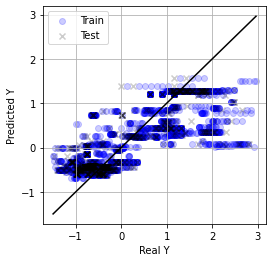

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, lasso.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, lasso.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [38]:
rmse_sum['Linear Regression(Lasso)'] = [RMSE_train, RMSE_test] 
r2_sum['Linear Regression(Lasso)'] = [R_square_train, R_square_test] 

## Ridge

In [39]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

Ridge(alpha=0.1)

In [40]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, ridge.predict(X_train))
RMSE_train = mean_squared_error(y_train, ridge.predict(X_train), squared=False)
R_square_test = r2_score(y_test, ridge.predict(X_test))
RMSE_test = mean_squared_error(y_test, ridge.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.8581634703346271
RMSE(Train): 0.378484131896999

R_square(Test): 0.8527607994386144
RMSE(Test): 0.3756323716544705


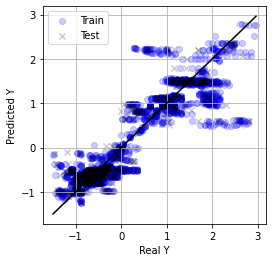

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, ridge.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, ridge.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [42]:
rmse_sum['Linear Regression(Ridge)'] = [RMSE_train, RMSE_test] 
r2_sum['Linear Regression(Ridge)'] = [R_square_train, R_square_test] 

## ElasticNet

In [43]:
from sklearn.linear_model import ElasticNet
EN = ElasticNet(alpha=0.1)
EN.fit(X_train, y_train)

ElasticNet(alpha=0.1)

In [44]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, EN.predict(X_train))
RMSE_train = mean_squared_error(y_train, EN.predict(X_train), squared=False)
R_square_test = r2_score(y_test, EN.predict(X_test))
RMSE_test = mean_squared_error(y_test, EN.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.6822358682219423
RMSE(Train): 0.5665080229514592

R_square(Test): 0.6819346083852269
RMSE(Test): 0.5520895097397663


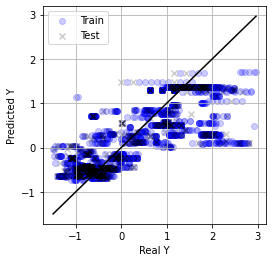

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, EN.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, EN.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [46]:
rmse_sum['Linear Regression(ElasticNet)'] = [RMSE_train, RMSE_test] 
r2_sum['Linear Regression(ElasticNet)'] = [R_square_train, R_square_test] 

## RF

In [47]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [48]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, rf.predict(X_train))
RMSE_train = mean_squared_error(y_train, rf.predict(X_train), squared=False)
R_square_test = r2_score(y_test, rf.predict(X_test))
RMSE_test = mean_squared_error(y_test, rf.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.9996259735153332
RMSE(Train): 0.01943590669986252

R_square(Test): 0.9975795438707313
RMSE(Test): 0.04816148780194008


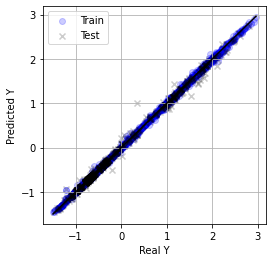

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, rf.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, rf.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [50]:
rmse_sum['RF'] = [RMSE_train, RMSE_test]
r2_sum['RF'] = [R_square_train, R_square_test] 

## SVR

In [51]:
# from sklearn.svm import SVR
# svr = SVR()
# svr.fit(X_train, y_train)

In [52]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# R_square_train = r2_score(y_train, svr.predict(X_train))
# RMSE_train = mean_squared_error(y_train, svr.predict(X_train), squared=False)
# R_square_test = r2_score(y_test, svr.predict(X_test))
# RMSE_test = mean_squared_error(y_test, svr.predict(X_test), squared=False)

# print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
# print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

In [53]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(4,4))
# plt.scatter(y_train, svr.predict(X_train), alpha=0.2, c="blue", label='Train')
# plt.scatter(y_test, svr.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
# plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
# plt.legend()
# plt.grid()
# plt.xlabel("Real Y")
# plt.ylabel("Predicted Y")
# plt.show()

In [54]:
# rmse_sum['SVR'] = [RMSE_train, RMSE_test] 
# r2_sum['SVR'] = [R_square_train, R_square_test] 

## XGB

In [55]:
# import xgboost as xgb
# xgb_reg = xgb.XGBRegressor()
# params = {'metric':'rmse',
#           'objective':'reg:squarederror',
#           'n_estimators':5000,
#           'booster': 'gbtree',
#           'learning_rate':0.01,
#           'min_child_weight':1,
#           'max_depth':5,
#           'random_state':0,
#           'colsample_bytree':1,
#           'subsample':1,
#          }
# xgb_reg.set_params(**params)
# xgb_reg.fit(X_train, y_train)

In [56]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# R_square_train = r2_score(y_train, xgb_reg.predict(X_train))
# RMSE_train = mean_squared_error(y_train, xgb_reg.predict(X_train), squared=False)
# R_square_test = r2_score(y_test, xgb_reg.predict(X_test))
# RMSE_test = mean_squared_error(y_test, xgb_reg.predict(X_test), squared=False)

# print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
# print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

In [57]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(4,4))
# plt.scatter(y_train, xgb_reg.predict(X_train), alpha=0.2, c="blue", label='Train')
# plt.scatter(y_test, xgb_reg.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
# plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
# plt.legend()
# plt.grid()
# plt.xlabel("Real Y")
# plt.ylabel("Predicted Y")
# plt.show()

In [58]:
# rmse_sum['XGBoost'] = [RMSE_train, RMSE_test] 
# r2_sum['XGBoost'] = [R_square_train, R_square_test] 

## GpyTorch

In [59]:
# from sklearn.preprocessing import MinMaxScaler,StandardScaler

# # X must be in the range=(0, 1)
# # use MinMaxScaler to transform features
# mmscaler = MinMaxScaler()
# X_train_mm = mmscaler.fit_transform(X_train)
# X_test_mm = mmscaler.transform(X_test)


# X_train_tensor = torch.from_numpy(np.array(X_train_mm))
# X_test_tensor = torch.from_numpy(np.array(X_test_mm))


# # Y must be in the range=(-1, 1)
# y_scaler = StandardScaler()

# y_train_s = y_scaler.fit_transform(y_train.reshape(-1, 1))
# y_test_s = y_scaler.transform(y_test.reshape(-1, 1))

# y_train_tensor = torch.from_numpy(np.array(y_train_s))
# y_test_tensor = torch.from_numpy(np.array(y_test_s))

In [60]:
# kernel = RBFKernel(ard_num_dims=X.shape[1])

# gp = SingleTaskGP(X_train_tensor, y_train_tensor, covar_module=kernel)
# mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

# fit_gpytorch_model(mll)

In [61]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# y_train_pred = gp.posterior(X_train_tensor).mean.detach().numpy().copy()
# y_train_var = gp.posterior(X_train_tensor).variance.detach().numpy().copy()

# y_test_pred = gp.posterior(X_test_tensor).mean.detach().numpy().copy()
# y_test_var = gp.posterior(X_test_tensor).variance.detach().numpy().copy()

# R_square_train = r2_score(y_train_s, y_train_pred)
# RMSE_train = mean_squared_error(y_scaler.inverse_transform(y_train_s), y_scaler.inverse_transform(y_train_pred), squared=False)
# R_square_test = r2_score(y_test_s, y_test_pred)
# RMSE_test = mean_squared_error(y_scaler.inverse_transform(y_test_s), y_scaler.inverse_transform(y_test_pred), squared=False)

# print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
# print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

In [62]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(4,4))
# plt.scatter(y_train_s, y_train_pred, alpha=0.2, c="blue", label='Train')
# plt.scatter(y_test_s, y_test_pred, alpha=0.2, c="black", marker='x', label='Test')
# plt.plot([y_train_s.min(), y_train_s.max()], [y_train_s.min(), y_train_s.max()], c="black")
# plt.legend()
# plt.grid()
# plt.xlabel("Real Y")
# plt.ylabel("Predicted Y")
# plt.show()

In [63]:
# rmse_sum['GP'] = [RMSE_train, RMSE_test] 
# r2_sum['GP'] = [R_square_train, R_square_test] 

# **Summary**

In [64]:
summary = pd.DataFrame(rmse_sum, index=['Train', 'Test'])
summary.style.set_caption("Table of RMSE")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF
Train,0.590204,0.378484,0.566508,0.019436
Test,0.571281,0.375632,0.552090,0.048161


In [65]:
summary = pd.DataFrame(r2_sum, index=['Train', 'Test'])
summary.style.set_caption("Table of R square")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF
Train,0.655097,0.858163,0.682236,0.999626
Test,0.659437,0.852761,0.681935,0.997580


# **Feature Importance**

Text(0.5, 0, 'Feature Importance')

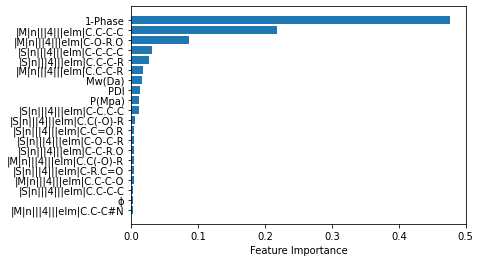

In [66]:
#w/o ϕ
sort = rf.feature_importances_.argsort()
plt.barh(f_new.iloc[:, :-1].columns[sort].astype(str)[-20:], rf.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

model_output = "margin" has been renamed to model_output = "raw"


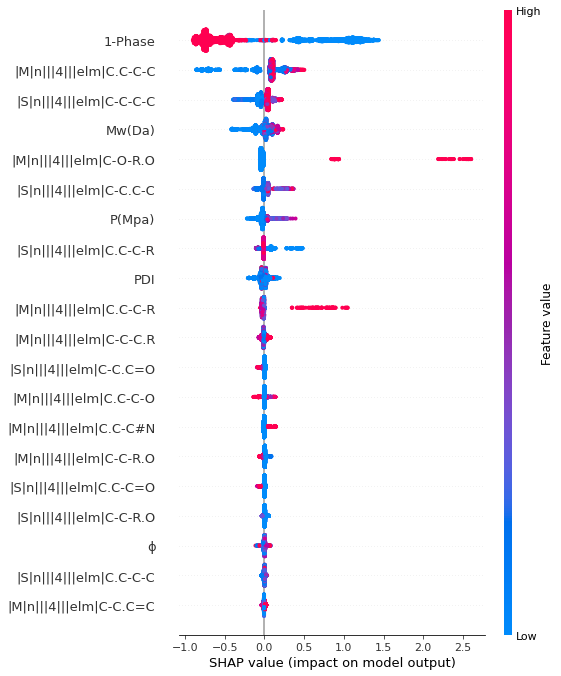

In [67]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model=rf, feature_perturbation='tree_path_dependent', model_output='margin')
shap_values = explainer.shap_values(X=f_new.iloc[:, :-1])
shap.summary_plot(shap_values, f_new.iloc[:, :-1])